In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
#from models import AlexNet
from torchvision import models
import os
import sys
sys.path.append('..')
import visualization
from visualization.gradcam import GradCam
from visualization import misc_functions
from visualization.misc_functions import get_params, save_class_activation_on_image, show_class_activation_on_image

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = '../data/'
test_dir = 'normal_test'
classes = sorted(os.listdir(data_dir + test_dir))
batch_size = 8

In [19]:
mean = [0.44947562, 0.46524084, 0.40037745]
std = [0.18456618, 0.16353698, 0.20014246]
#mean = [0.14318287, 0.19182085, 0.10939839]
#std = [0.20657195, 0.25984347, 0.1585114]

data_transforms = {
        'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])}

test_images = datasets.ImageFolder(os.path.join(data_dir, test_dir),
                    data_transforms['test'])

test_dataloader = DataLoader(test_images, batch_size=batch_size, shuffle=False, num_workers=4)

In [10]:
model = models.AlexNet()
model.classifier[6] = nn.Linear(4096, 10)
model.load_state_dict(torch.load('alexnet_pretrained_erba.model', map_location=str(device)))
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [28]:
def image_show(tensors):

    num_rows = 1
    num_cols = len(labels)
    fig = plt.figure(figsize=(num_cols, num_rows))
    plt.title("default")
    i = 0
    for t in tensors:
        t = np.transpose(t.cpu().numpy(), (1, 2, 0))
        t = np.asarray(std).mean() * t + np.asarray(mean).mean()
        t = np.clip(t, 0, 1)

        ax1 = fig.add_subplot(num_rows, num_cols, i+1)
        fig.set_size_inches(18.5, 10.5)
        ax1.imshow(t, interpolation='none')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_title('Default')
        i += 1

    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.tight_layout()
    plt.show()

In [ ]:
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        for layer in model.get_features:
            outputs = layer(inputs)
            inputs = outputs
            if isinstance(layer, nn.Conv2d):
                for i in range(len(outputs)):
                    imshow(outputs[i], outputs[i].size()[0])
                    break
                break
        break

In [ ]:
def plot_kernels(tensor, num_cols):
    """
    mean = 0.5
    std = 0.5
    maxVal = tensor.max()
    minVal = abs(tensor.min())
    maxVal = max(maxVal,minVal)
    tensor = tensor / maxVal
    tensor = tensor / 2
    tensor = tensor + 0.5
    """
    #tensor = tensor * np.asarray(std).mean() + np.asarray(mean).mean()
    num_rows = 1
    fig = plt.figure(figsize=(num_cols, num_rows))
    i = 0
    for t in tensor:
        ax1 = fig.add_subplot(num_rows, num_cols, i+1)
        pilTrans = transforms.ToPILImage()
        pilImg = pilTrans(t)
        ax1.imshow(pilImg, interpolation='none')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        i += 1
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        plot_kernels(m.weight.data, len(m.weight.data))
        break

In [ ]:
# plot filter by filter
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        for i in range(m.weight.shape[0]):
            imshow(m.weight.data[i], m.weight.shape[0])
            break
        break

In [ ]:
from sklearn.manifold import TSNE

perplexity=20
tsne = TSNE(learning_rate=50, random_state=1234)
tsne_result = tsne.fit_transform(model.get_classifier[4].weight.data)

In [ ]:
features = {'x':tsne_result[:,0], 'y':tsne_result[:,1]}
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('x', fontsize = 15)
ax.set_ylabel('y', fontsize = 15)
ax.set_title('t-SNE (2 Components)', fontsize = 20)
targets = classes
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    #indicesToKeep = features['classes'] == target
    ax.scatter(features['x'], features['y'], c=color, s=50)
ax.legend(targets)
ax.grid()

In [5]:
def image_show(img):
    img = np.asarray(std).mean() * img + np.asarray(mean).mean()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.pause(0.001)

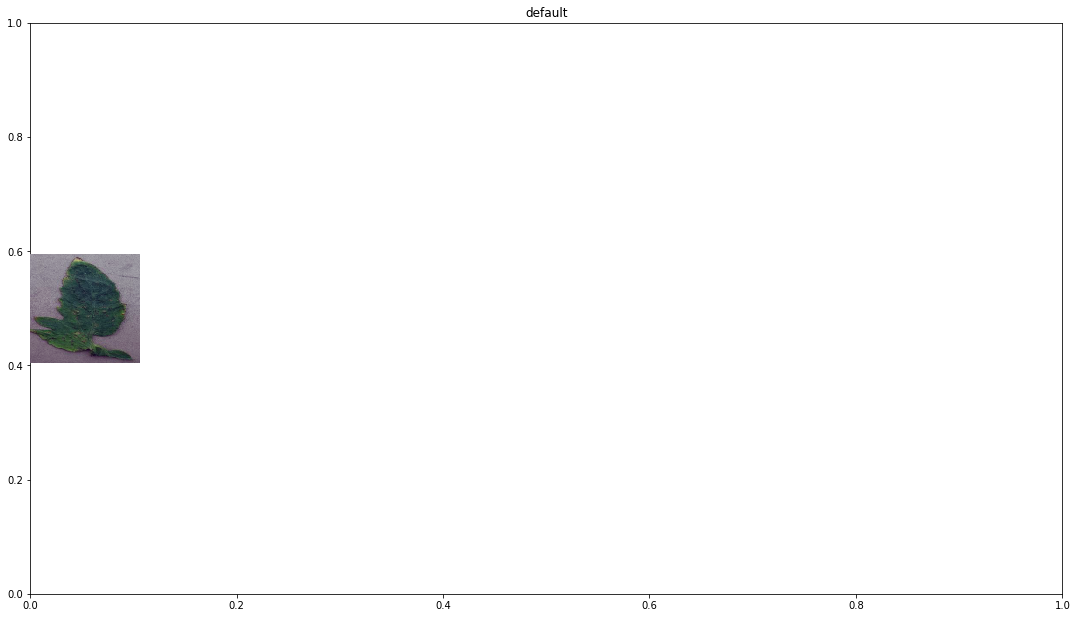

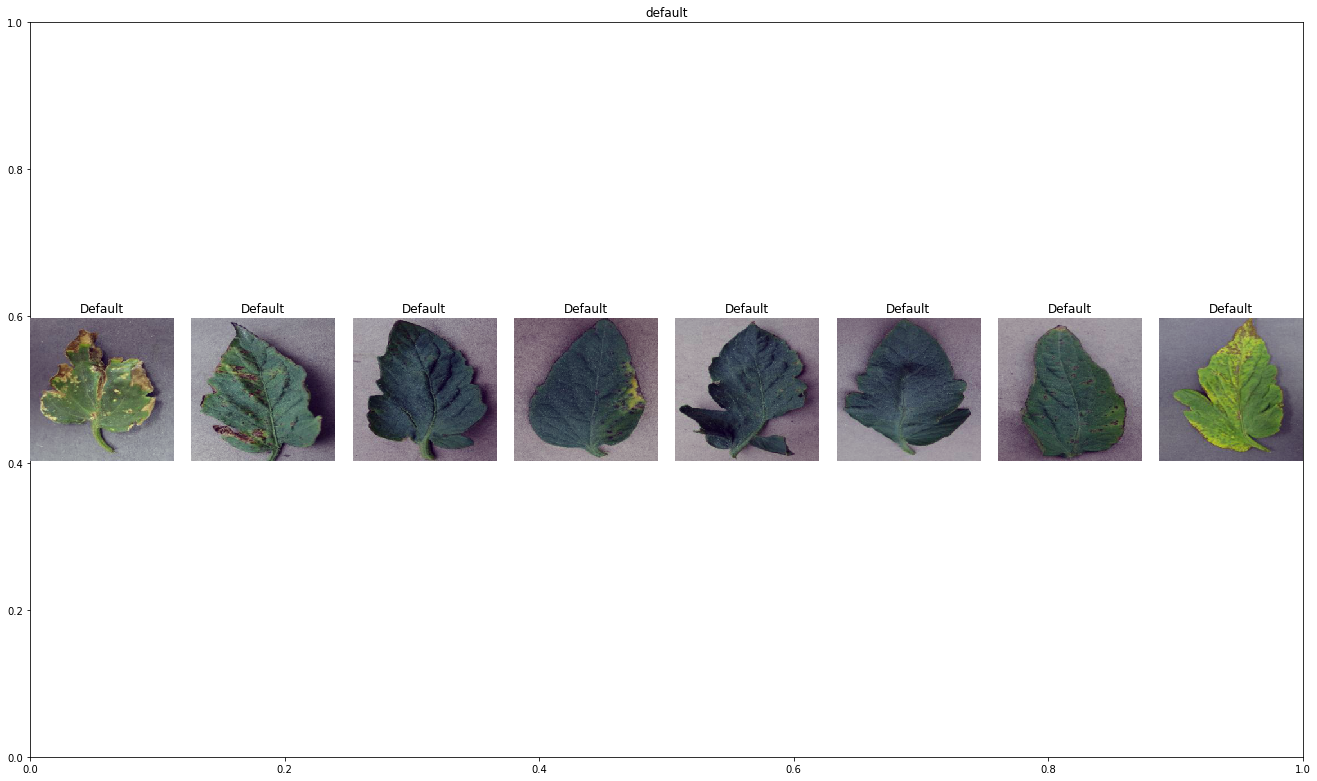

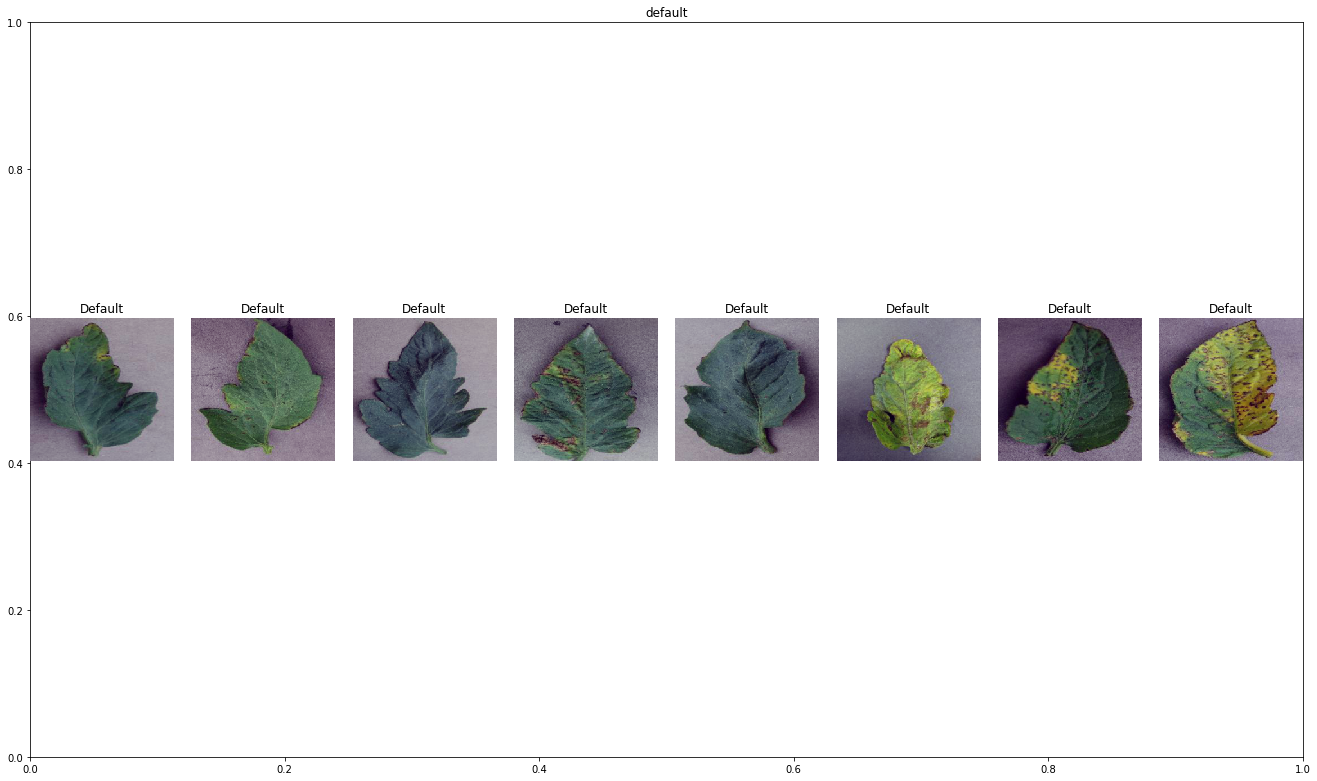

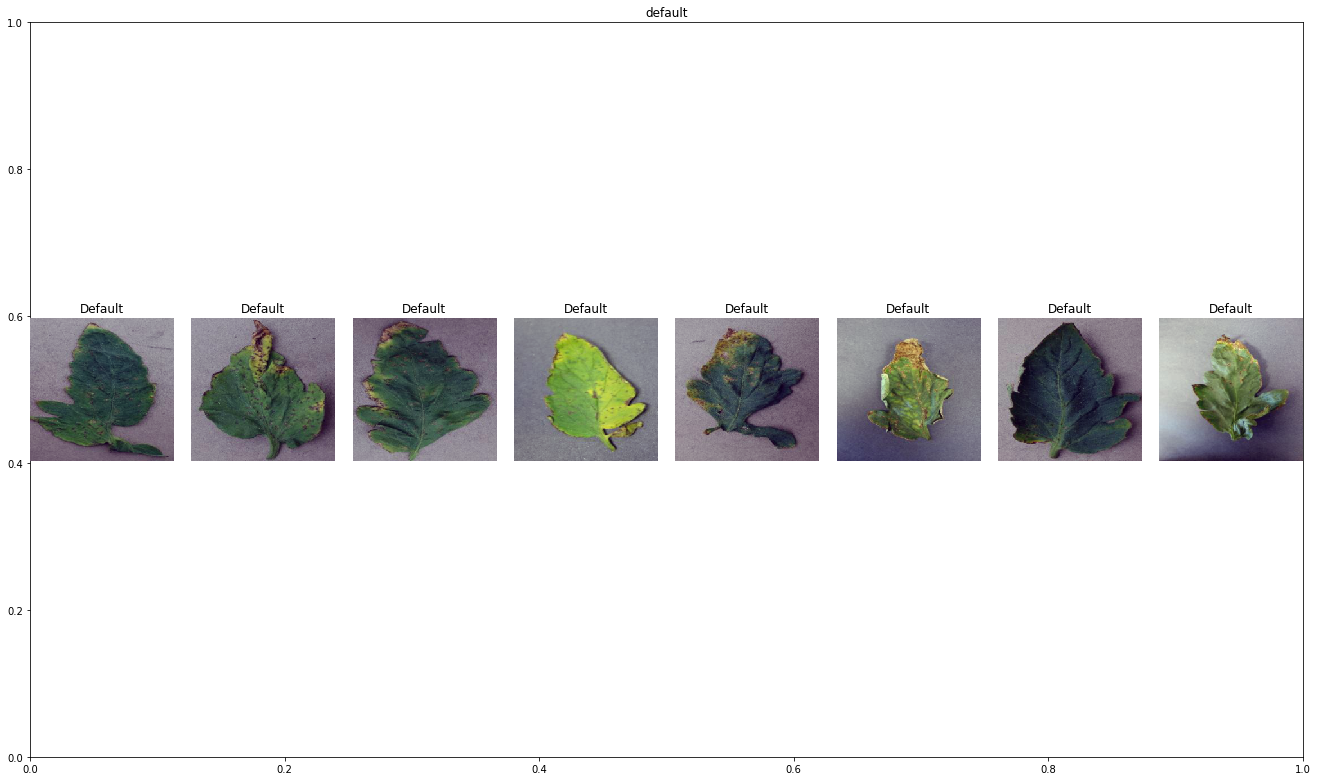

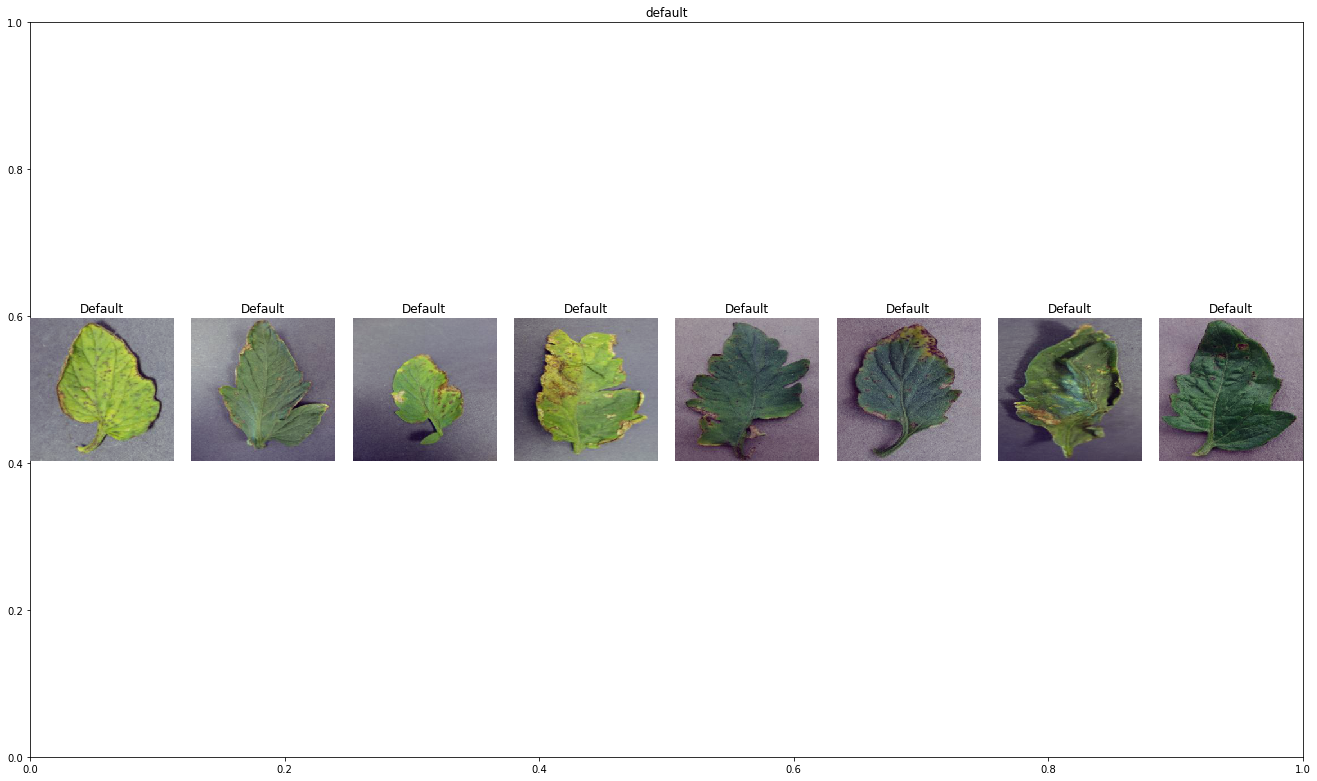

Process Process-42:
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-43:
Traceback (most recent call last):
Process Process-44:
Process Process-41:
Traceback (most recent call last):
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mirco/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mirco/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/mirco/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  

KeyboardInterrupt: 

In [29]:
file_name_to_export = "prova"
grad_cam = GradCam(model, target_layer=11)
model.train()
#with torch.no_grad():
for data in test_dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    for i in range(len(inputs)):
        if(labels[i] == 2):
            original = np.transpose(inputs[i].numpy(),(1,2,0))
            single_input = inputs[i].unsqueeze_(0)
            cam = grad_cam.generate_cam(single_input, labels[i])
            print(classes[labels[i]])
            image_show(original)
            show_class_activation_on_image(original, cam)
            #save_class_activation_on_image(np.transpose(inputs[i].numpy(),(1,2,0)), cam, file_name_to_export)
        
        #cam = grad_cam.generate_cam(inputs, labels)
        #save_class_activation_on_image(original_image, cam, file_name_to_export)


In [5]:
import math
import copy
from PIL import Image

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.ToTensor(),
   normalize
])



def Occlusion_exp(image,occluding_size,occluding_stride,model,classes,groundTruth):
    img = np.copy(image)
    height, width,_= img.mode.shape
    output_height = int(math.ceil((height-occluding_size)/occluding_stride+1))
    output_width = int(math.ceil((width-occluding_size)/occluding_stride+1))
    ocludedImages=[]
    for h in range(output_height):
        for w in range(output_width):
            #occluder region
            h_start = h*occluding_stride
            w_start = w*occluding_stride
            h_end = min(height, h_start + occluding_size)
            w_end = min(width, w_start + occluding_size)
            
            input_image = copy.copy(img)
            input_image[h_start:h_end,w_start:w_end,:] =  0
            ocludedImages.append(preprocess(Image.fromarray(input_image)))
            
    L = np.empty(output_height*output_width)
    L.fill(groundTruth)
    L = torch.from_numpy(L)
    tensor_images = torch.stack([img for img in ocludedImages])
    dataset = torch.utils.data.TensorDataset(tensor_images,L) 
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=5,shuffle=False, num_workers=8) 

    heatmap=np.empty(0)
    model.eval()
    for data in test_dataloader:
        images, labels = data
        
        if use_gpu:
            images, labels = (images.cuda()), (labels.cuda(async=True))
        
        outputs = model(Variable(images))
        m = nn.Softmax()
        outputs=m(outputs)
        if use_gpu:   
            outs=outputs.cpu()
        heatmap = np.concatenate((heatmap,outs[0:outs.size()[0],groundTruth].data.numpy()))
        
    return heatmap.reshape((output_height, output_width))    

In [7]:
for data in test_dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    for i in range(len(inputs)):
        #if(labels[i] == 8):
        img = transforms.ToPILImage(inputs[i])
        heatmap=Occlusion_exp(img, 10, 10 ,model,labels,labels[i])
        break
    break

AttributeError: 'numpy.ndarray' object has no attribute 'mode'

In [ ]:
print(heatmap)